In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import confusion_matrix,accuracy_score, classification_report

In [2]:
#!pip install -U imblearn

In [3]:
data=pd.read_csv("C:/Users/archa/spam classification/spam_data_set.csv")

In [4]:
data.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
data.shape

(5572, 2)

In [6]:
data["Category"].value_counts()

ham     4825
spam     747
Name: Category, dtype: int64

In [7]:
print(data['Message'].apply(lambda x: len(x.split(' '))).sum())

87265


In [8]:
data["Category"]=data["Category"].map({"ham":0,"spam":1})

In [9]:
data.head()

,Category,Message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [10]:
data["Message"][3]

'U dun say so early hor... U c already then say...'

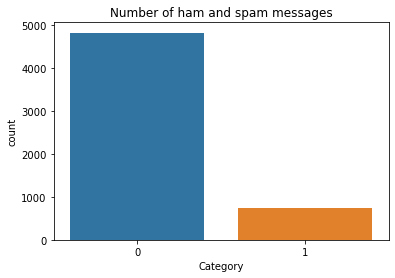

In [11]:
sns.countplot(x="Category", data=data)
plt.xlabel('Category')
plt.title('Number of ham and spam messages');

In [12]:
data.describe()

,Category
count,5572.000000
mean,0.134063
std,0.340751
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [13]:
#length of the text messages
data["Length"]=data.Message.apply(len)
data.head()

,Category,Message,Length
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,0,U dun say so early hor... U c already then say...,49
4,0,"Nah I don't think he goes to usf, he lives aro...",61


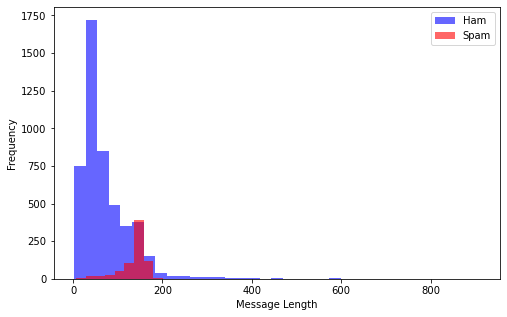

In [14]:
plt.figure(figsize=(8, 5))
data[data.Category == 0].Length.plot(bins=35, kind='hist', color='blue', label='Ham', alpha=0.6)
data[data.Category == 1].Length.plot(kind='hist', color='red', label='Spam', alpha=0.6)
plt.legend()
plt.xlabel("Message Length");

Text Pre-processing

In the next step we clean text, remove stop words and apply stemming operation for each line of text:

In [15]:
stop_words =stopwords.words('english')
print(stop_words[::10])
porter = PorterStemmer()

['i', "you've", 'himself', 'they', 'that', 'been', 'a', 'while', 'through', 'in', 'here', 'few', 'own', 'just', 're', 'doesn', 'ma', "shouldn't"]


In [16]:
def clean_text(words):
    """The function to clean text"""
    words = re.sub("[^a-zA-Z]", " ",words)
    text=words.lower().split()
    return " ".join(text)

def remove_stopwords(text):
    """The function to removing stopwords"""
    text = [word.lower() for word in text.split() if word.lower() not in stop_words]
    return " ".join(text)

def stemmer(stem_text):
    """The function to apply stemming"""
    stem_text = [porter.stem(word) for word in stem_text.split()]
    return " ".join(stem_text)

In [17]:
#applying clean_text function, you can see it convert all the alphabets into lower case
data["Message"]=data["Message"].apply(clean_text)
data.head()

,Category,Message,Length
0,0,go until jurong point crazy available only in ...,111
1,0,ok lar joking wif u oni,29
2,1,free entry in a wkly comp to win fa cup final ...,155
3,0,u dun say so early hor u c already then say,49
4,0,nah i don t think he goes to usf he lives arou...,61


In [18]:
#applying remove_stopwords function, you can see it remove stop word like only, is,are and so on 
data["Message"]=data["Message"].apply(remove_stopwords)
data.head()

,Category,Message,Length
0,0,go jurong point crazy available bugis n great ...,111
1,0,ok lar joking wif u oni,29
2,1,free entry wkly comp win fa cup final tkts st ...,155
3,0,u dun say early hor u c already say,49
4,0,nah think goes usf lives around though,61


In [19]:
#applying stemmer function, you can see it convert the word into root word
data["Message"]=data["Message"].apply(stemmer)
data.head()

,Category,Message,Length
0,0,go jurong point crazi avail bugi n great world...,111
1,0,ok lar joke wif u oni,29
2,1,free entri wkli comp win fa cup final tkt st m...,155
3,0,u dun say earli hor u c alreadi say,49
4,0,nah think goe usf live around though,61


In [20]:
print(data['Message'].apply(lambda x: len(x.split(' '))).sum())

50290


we can see After text cleaning and removing stop words, we have only 50290 words.(before cleaning we have 87265 words) 

In [21]:
data.to_csv("C:/Users/archa/spam classification/spam_clean.csv")

After text cleaning and removing stop words, we have only 50290 words.

Vectorization:

To run machine learning algorithms we need to convert text files into numerical feature vectors. We will use bag of words model for our analysis.

First we spliting the data into X and y values:

In [22]:
x=data["Message"]
y=data["Category"]

Now, we create a numerical feature vector for each document:

In [23]:
vect = CountVectorizer(min_df=5, ngram_range=(1,2)).fit(x) 
# if there is any numeric value in x(or message column) it will throw arrome

X_vec = vect.transform(x)

len(vect.get_feature_names())

C:\Users\archa\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


2228

We spliting the data into train and test sets:

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X_vec, y, test_size=0.2, random_state = 0)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(4457, 2228)
(1115, 2228)
(4457,)
(1115,)


### SMOTE


The target class variable is imbalanced, "ham" values are more dominating than "spam". The simplest way to improve imbalanced dataset is balancing them by oversampling instances of the minority class or undersampling instances of the majority class. We will try to balancing classes by using one of the advanced techniques like the SMOTE method (Synthetic Minority Over-sampling Technique).

SMOTE technique is one of the most commonly used oversampling methods to solve the imbalance problem. It goal is to balance class distribution by randomly increasing minority class examples by replicating them.

We will use imbalanced-learn library to apply SMOTE method:

In [25]:
smote = SMOTE()
X_train_sm,y_train_sm = smote.fit_resample(X_train,y_train)

In [26]:
print(X_train_sm.shape)
print(y_train_sm.shape)

(7740, 2228)
(7740,)


### Logistic regression

In [27]:
model_lr = Pipeline([('tfidf', TfidfTransformer()),
                   ('model',LogisticRegression()),
                   ])

model_lr.fit(X_train_sm,y_train_sm)

ytest = np.array(y_test)
pred_y = model_lr.predict(X_test)

In [28]:
print('accuracy %s' % accuracy_score(pred_y, y_test))
print(classification_report(ytest, pred_y))

accuracy 0.9381165919282511
              precision    recall  f1-score   support

           0       0.98      0.94      0.96       955
           1       0.73      0.91      0.81       160

    accuracy                           0.94      1115
   macro avg       0.86      0.93      0.89      1115
weighted avg       0.95      0.94      0.94      1115



### Naive Bayes:

In [29]:
model_nb = Pipeline([('tfidf', TfidfTransformer()),
                   ('model',MultinomialNB()),
                   ])

model_nb.fit(X_train_sm,y_train_sm)

ytest = np.array(y_test)
pred = model_nb.predict(X_test)

print('accuracy %s' % accuracy_score(pred, y_test))
print(classification_report(ytest, pred))

accuracy 0.967713004484305
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       955
           1       0.88      0.89      0.89       160

    accuracy                           0.97      1115
   macro avg       0.93      0.94      0.93      1115
weighted avg       0.97      0.97      0.97      1115



### Random Forest Classifier

In [30]:
model_rf = Pipeline([('tfidf', TfidfTransformer()),
                   ('model',RandomForestClassifier(n_estimators=70)),
                   ])

model_rf.fit(X_train_sm,y_train_sm)

ytest = np.array(y_test)
preds = model_rf.predict(X_test)

print('accuracy %s' % accuracy_score(preds, y_test))
print(classification_report(ytest, preds))

accuracy 0.9318385650224216
              precision    recall  f1-score   support

           0       0.99      0.93      0.96       955
           1       0.70      0.93      0.80       160

    accuracy                           0.93      1115
   macro avg       0.84      0.93      0.88      1115
weighted avg       0.95      0.93      0.94      1115



### Gradient Boosting:

In [31]:
model_gb = Pipeline([('tfidf', TfidfTransformer()),
                    ('model', GradientBoostingClassifier(random_state=100, n_estimators=100,min_samples_split=100, max_depth=6)),
                    ])

model_gb.fit(X_train_sm,y_train_sm)

ytest = np.array(y_test)
y_pred = model_gb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(ytest, y_pred))

accuracy 0.9605381165919282
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       955
           1       0.83      0.92      0.87       160

    accuracy                           0.96      1115
   macro avg       0.91      0.94      0.92      1115
weighted avg       0.96      0.96      0.96      1115



### Support Vector Machine

In [32]:
model_svc = Pipeline([('tfidf', TfidfTransformer()),
                     ('model',LinearSVC()),
                     ])

model_svc.fit(X_train_sm,y_train_sm)

ytest = np.array(y_test)
predict = model_svc.predict(X_test)

print('accuracy %s' % accuracy_score(predict, y_test))
print(classification_report(ytest, predict))

accuracy 0.9390134529147982
              precision    recall  f1-score   support

           0       0.99      0.94      0.96       955
           1       0.73      0.93      0.81       160

    accuracy                           0.94      1115
   macro avg       0.86      0.93      0.89      1115
weighted avg       0.95      0.94      0.94      1115



### Stochastic Gradient Descent

In [33]:
model_sg = Pipeline([('tfidf', TfidfTransformer()),
                     ('model',SGDClassifier()),
                     ])

model_sg.fit(X_train_sm,y_train_sm)

ytest = np.array(y_test)
predicted = model_sg.predict(X_test)
print('accuracy %s' % accuracy_score(predicted, y_test))
print(classification_report(ytest, predicted))

accuracy 0.9291479820627803
              precision    recall  f1-score   support

           0       0.98      0.93      0.96       955
           1       0.69      0.91      0.79       160

    accuracy                           0.93      1115
   macro avg       0.84      0.92      0.87      1115
weighted avg       0.94      0.93      0.93      1115



#### Best Model

We tested six different models and now, we check which one is the best:

In [34]:
log_acc = accuracy_score(pred_y, y_test)
nb_acc = accuracy_score(pred, y_test)
rf_acc = accuracy_score(preds, y_test)
gb_acc = accuracy_score(y_pred, y_test)
svm_acc = accuracy_score(predict, y_test)
sg_acc = accuracy_score(predicted, y_test)

In [35]:
models = pd.DataFrame({
                      'Model': ['Logistic Regression', 'Naive Bayes', 'Random Forest', 'Gradient Boosting', 'SVM', 'SGD'],
                      'Score': [log_acc, nb_acc, rf_acc, gb_acc, svm_acc, sg_acc]})
models.sort_values(by='Score', ascending=False)

,Model,Score
1,Naive Bayes,0.967713
3,Gradient Boosting,0.960538
4,SVM,0.939013
0,Logistic Regression,0.938117
2,Random Forest,0.931839
5,SGD,0.929148


we can see navie bayes classification model gives high accuracy as compare to other model. so we will crete pickel file of that model.

In [36]:
import pickle


In [38]:
pickle.dump(model_nb,open("SpamDetection_NBModel_pickle.pkl","wb"))